# Comparing the K-profile parameterization in `GOTM` and `OceanTurb.jl`

In [1]:
using Pkg; Pkg.activate("..")
using OceanTurb, OceanTurb.Plotting, PyPlot

┌ Info: Recompiling stale cache file /Users/gregorywagner/.julia/compiled/v1.1/OceanTurb/9iboO.ji for OceanTurb [d848d694-35fd-11e9-1c91-9995598ac29e]
└ @ Base loading.jl:1184


# A simple class of initial value problems

We consider initial value problems with simple initial conditions and constant atmospheric fluxes.
The problems are initialized with zero velocity fields and a linear temperature stratification, so that

$$ U = V = 0 \, , \qquad S = S_0 \, , $$

and

$$ T = T_0 + \mathrm{smoothstep} \left ( z + h_0, d \right ) \gamma z \, , $$

where the function $\mathrm{smoothstep}(z, d)$ is the smooth Heaviside function

$$ \mathrm{smoothstep}(z, d) = \tfrac{1}{2} \left ( 1 - \tanh[z/d] \right ) \, . $$

This initial condition corresponds to a density profile that is well-mixed to a depth of $z=-h_0$
and linearly stratified below with a temperature gradient $\gamma$.
The initial interior temperature gradient $\gamma$ corresponds to an initial buoyancy frequency $N_0$

$$ N_0^2 = \alpha g \gamma \approx 2.45 \times 10^{-3} \gamma $$

with $\alpha = 2.5 \times 10^{-4} \, \mathrm{C^{-1}}$ 
and $g = 9.81 \, \mathrm{m \, s^{-2}}$.

To implement these cases we write a function, `simple_flux_model` that sets up the `OceanTurb.KPP` model and also allows us to set arbitrary `parameters`.

In [2]:
smoothstep(z, d) = 0.5 * (1 - tanh(z/d))

function simple_flux_model(; N=256, L=100, Tz=0.01, Fb=-2.509e-10, Fu=-1.44e-4, h₀=42, d=2L/N, parameters=KPP.Parameters(),
                             constants=KPP.Constants(α=2e-4, ρ₀=1000, cP=3985, f=2Ω*sin(45*π/180)))
    
    model = KPP.Model(N=N, L=L, constants=constants, parameters=parameters, stepper=:BackwardEuler)

    # Initial condition
    T₀(z) = 20 + Tz*z * smoothstep(z+h₀, d)
    
    # Set T to the function T0(z)
    model.solution.T = T₀

    # Fluxes
    Fθ = Fb / (model.constants.α * model.constants.g)
    model.bcs.U.top = FluxBoundaryCondition(Fu)
    model.bcs.T.top = FluxBoundaryCondition(Fθ)
    model.bcs.T.bottom = GradientBoundaryCondition(Tz)
    
    return model
end

simple_flux_model (generic function with 1 method)

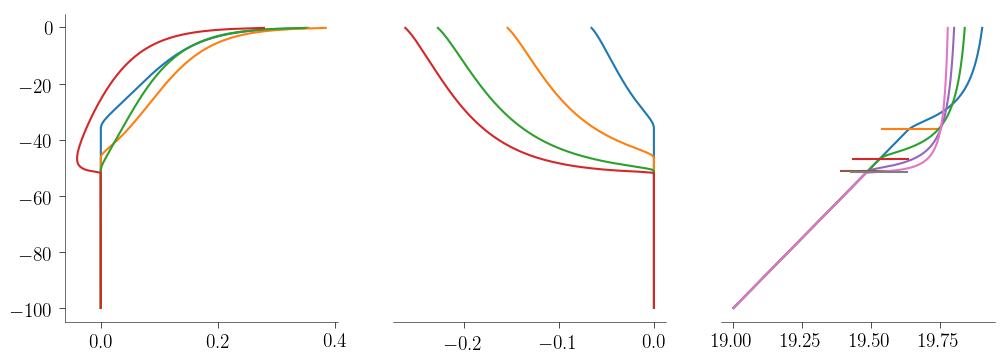

In [19]:
model = simple_flux_model(h₀=10, Fb=-1e-10, Fu=-5e-4)

function at_depth(ϕ, h)
    ih = searchsortedfirst(ϕ.grid.zc, -h)
    return ϕ[ih]
end

fig, axs = subplots(ncols=3, figsize=(12, 4))

dt = 600
nt = ceil(Int, 2*hour/dt)
    
for i = 1:4      
    iterate!(model, dt, nt)
    U, V, T, S = model.solution
    
    h = model.state.h
    
    sca(axs[1])
    plot(U)
    cornerspines()
    
    sca(axs[2])
    plot(V)
    bottomspine()
    
    sca(axs[3])
    plot(T)
    plot(at_depth(T, h) .+ 0.1*[-1, 1], -h*[1, 1])
    bottomspine()
end